In [1]:
import numpy as np # primary math library
import matplotlib.pyplot as plt # primary plotting library
%matplotlib inline

import nelpy as nel # should be installed using pip install nelpy

import warnings
#warnings.filterwarnings("ignore") # useful to prevent excess nelpy warnings

/home/kemerelab/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
# dataroot = '/Users/ckemere/Development/Data/Frank/';
dataroot = '/home/kemerelab/Data/'

In [3]:
import os

filename = os.path.join(dataroot,'MVDMData.nel')
import nelpy.io
jar = nel.load_pkl(filename)

data = jar.Data
del jar


In [4]:
data.keys()

dict_keys(['R042'])

# Calculate tuning curves for all neurons for an example animal

In [6]:
from numpy import unravel_index
    
sigma_500ms = 0.5 # Smoothing for speed calculation
# Bin sizes are 500 ms, and then we slide
ds_run = 0.250 # 250 ms
ds_50ms = 0.05

sigma_250ms = 0.25 # 250 ms spike smoothing

min_duration = 1 # require that estimation periods be at least 1 second long

# Smoothing standard deviation
sigma_tc = 2.5 # tuning curve smoothing std in cm
min_spikes = 5

PFCenters = {}
TuningCurves = {}

for anim, animdata in data.items():
    PFCenters[anim] = {}
    TuningCurves[anim] = {}
    
    for day, daydata in animdata.items():
        print(anim, day)
        S = daydata['spikes']
        pos = daydata['pos']

        # Bins for tuning curves
        if (anim == 'R042'):
            x_extents = [25,225] # Read these off of maze figure above
            y_extents = [0,210]
        
        nx = np.diff(x_extents)/5 # plan for 5 cm bins
        ny = np.diff(y_extents)/5

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)

        # get_run_epochs is a utility function which wraps a speed threshold. This finds periods where the speed
        #   is greater than v2 and reaches at least a maximum of v1.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
            run_epochs = pos.support.intersect(run_epochs)    

        st_run = S[run_epochs]

        # bin, smooth and re-bin:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma_250ms, inplace=True).rebin(w=ds_run/ds_50ms)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tc = nel.TuningCurve2D(bst=bst_run, extern=pos, 
                                   ext_xmin=x_extents[0], ext_xmax=x_extents[1], 
                                   ext_ymin=y_extents[0], ext_ymax=y_extents[1],
                                   ext_nx=nx, ext_ny=ny,
                                   sigma=sigma_tc, min_duration=1)

        TuningCurves[anim][day] = tc
        PFCenters[anim][day] = []

        for idx, pf in enumerate(tc.ratemap):
            placefield = pf.T
            peak = unravel_index(placefield.squeeze().argmax(),placefield.shape)
            PFCenters[anim][day].append([idx, placefield.max(), peak[0], peak[1]])

    


R042 2013-08-18


# Plot an example tuning curve

In [7]:
anim = 'R042'
day = '2013-08-18'

/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


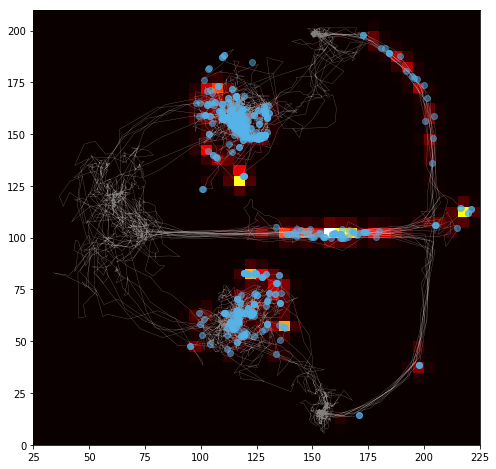

In [10]:
import nelpy.plotting as npl

tc = TuningCurves[anim][day]
xx_mid = tc.xbin_centers
yy_mid = tc.ybin_centers

S = data[anim][day]['spikes']
pos = data[anim][day]['pos']

speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)
run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
run_epochs = pos.support.intersect(run_epochs)  
runpos = pos[run_epochs]


fig, ax = plt.subplots(1,1, figsize = (8, 8))

xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals

nidx = 2
xspks, yspks = runpos.asarray(at=S[run_epochs].time[nidx]).yvals

ax.set_aspect('equal')
placefield = tc.ratemap[nidx]
npl.imagesc(x=xx_mid, y=yy_mid, data=placefield.T, cmap=plt.cm.hot, ax=ax)
ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
ax.plot(xspks, yspks, 'o', color=npl.colors.sweet.blue, alpha=0.5)



In [10]:
jar = nel.load_pkl('NovelCenterBounds.nel')
NovelCenterBounds = jar.NovelCenterBounds


(38, 8) 38 (38,) (38,) (38,) (38,)
(74, 8) 74 (74,) (74,) (74,) (74,)
(60, 8) 60 (60,) (60,) (60,) (60,)
(67, 8) 67 (67,) (67,) (67,) (67,)
(62, 8) 62 (62,) (62,) (62,) (62,)
(49, 8) 49 (49,) (49,) (49,) (49,)
(64, 8) 64 (64,) (64,) (64,) (64,)
(61, 8) 61 (61,) (61,) (61,) (61,)


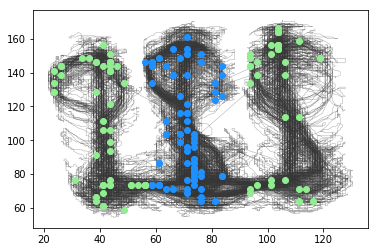

In [11]:
fig, ax = plt.subplots()
PF_data = {}

PF_arm = {}

CenterBounds = NovelCenterBounds[anim]

for day, daydata in data[anim].items():
    # The animal "Bon" had good data on day 3
    S = daydata['spikes']
    pos = daydata['pos']
    # Find placefield centers
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tvals, vals = pos[epochs,:].asarray() # Access timestamps and channel data as numpy arrays
    xvals, yvals = vals # Access two channels as x and y
    ax.plot(xvals, yvals, lw=0.5, c='0.2', alpha=0.4)

for day, daydata in data[anim].items():
    maxrate = np.array(PFCenters[anim][day])
    maxrate = maxrate[:,1]
    p = np.array(PFCenters[anim][day],dtype=int)
    pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T

    # Find left and right arm PFs as the direction of the projection vector
    #   from the dividing plane and the placefield center
    left = (np.cross(pfcenters-CenterBounds[0],CenterBounds[5]-CenterBounds[0]) < 0)
    right = (np.cross(pfcenters-CenterBounds[2],CenterBounds[3]-CenterBounds[2]) > 0)
    center = np.logical_and(np.logical_not(left), np.logical_not(right))
    
    left = np.logical_and(left, maxrate > 2)
    right = np.logical_and(right, maxrate > 2)
    center = np.logical_and(center, maxrate > 2)
    inactive = maxrate <= 2

    ax.plot(pfcenters[left,0], pfcenters[left,1],'o',c='lightgreen')
    ax.plot(pfcenters[right,0], pfcenters[right,1],'o',c='lightgreen')
    ax.plot(pfcenters[center,0], pfcenters[center,1],'o',c='dodgerblue')
    
    PF_data[day] = np.column_stack((np.array(PFCenters[anim][day]), np.array(inactive), 
                              np.array(center), np.array(left), np.array(right)));

    S = daydata['spikes']
    print(PF_data[day].shape, S.n_units, left.shape, right.shape, center.shape, inactive.shape)



(7308,)


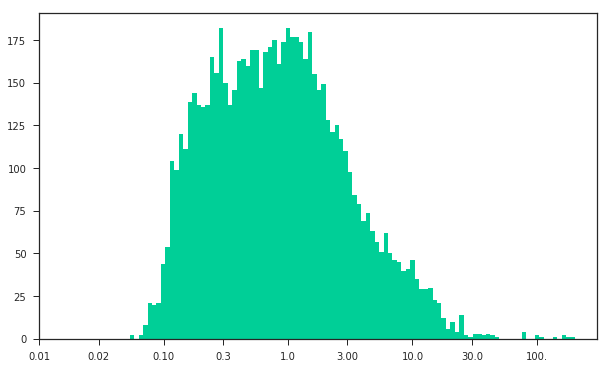

In [12]:
import nelpy.plotting as npl
# Set default figure aesthetics
npl.setup(font_scale=1)

post_sleep_epochs = [ep+1 for ep in epochs]
inter_swr_intervals = []
for day, swr_eps in SWREpochs[anim].items():
    for ep in post_sleep_epochs:
        post_sleep_swr = swr_eps.intersect(pos.support[ep])
        swrtimes = post_sleep_swr.centers
        inter_swr_intervals.append(np.diff(swrtimes))

inter_swr_intervals = np.hstack(inter_swr_intervals)
print(inter_swr_intervals.shape)
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):    
    ax.hist(np.log(inter_swr_intervals),bins=100);
    ax.set_xticks(np.log([0.01,0.03,0.1,0.3,1,3,10,30,100]))
    ax.set_xticklabels(np.exp(ax.get_xticks()).astype('|U4'))

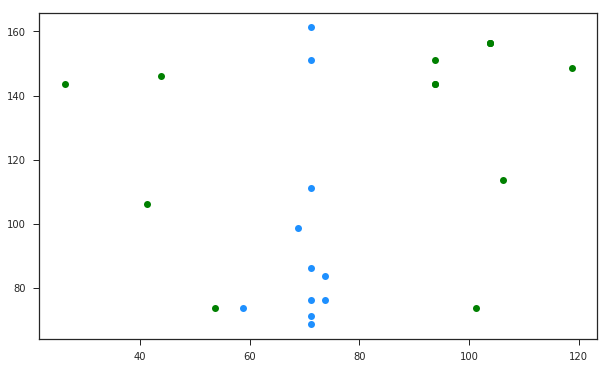

In [13]:
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):    
    maxrate = np.array(PFCenters[anim][day])
    maxrate = maxrate[:,1]
    p = np.array(PFCenters[anim][day],dtype=int)
    pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T

    # Find left and right arm PFs
    left = (np.cross(pfcenters-CenterBounds[0],CenterBounds[5]-CenterBounds[0]) < 0)
    right = (np.cross(pfcenters-CenterBounds[2],CenterBounds[3]-CenterBounds[2]) > 0)
    center = np.logical_and(np.logical_not(left), np.logical_not(right))
    
    left = np.logical_and(left, maxrate > 2)
    right = np.logical_and(right, maxrate > 2)
    center = np.logical_and(center, maxrate > 2)
    inactive = maxrate <= 2

    ax.plot(pfcenters[left,0], pfcenters[left,1],'o',c='green')
    ax.plot(pfcenters[right,0], pfcenters[right,1],'o',c='green')
    ax.plot(pfcenters[center,0], pfcenters[center,1],'o',c='dodgerblue')


/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


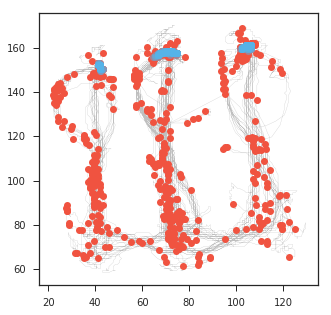

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
swr_eps = SWREpochs[anim][day]
#for ep in epochs:
pos = data[anim][day]['pos']
speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

not_still_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # bound epochs down to 1 cm/s
still_epochs = pos[epochs,:].support.intersect(not_still_epochs.complement()) 
still_pos = pos[epochs,:].support.intersect(still_epochs)

all_swr = swr_eps.intersect(pos[epochs,:].support)
allswrtimes = all_swr.centers
still_swr = swr_eps.intersect(still_epochs)
stillswrtimes = still_swr.centers

posx, posy = pos[epochs,:].asarray().yvals 
ax.plot(posx, posy, lw=0.25, color='gray', alpha=0.5)
xswr, yswr = pos.asarray(at=allswrtimes).yvals
ax.plot(xswr, yswr, 'o', color=npl.colors.sweet.red)
xswr1, yswr1 = pos.asarray(at=stillswrtimes).yvals
ax.plot(xswr1, yswr1, 'o', color=npl.colors.sweet.blue, alpha=0.5)





In [15]:
day

9

In [16]:
import pandas as pd

swr_table = []

for day, swr_eps in SWREpochs[anim].items():
    for ep in epochs:
        S = data[anim][day]['spikes']
        print(day,S.n_units, PF_data[day].shape)
        
        pos = data[anim][day]['pos']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            not_still_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # bound epochs down to 1 cm/s
            still_epochs = pos[epochs,:].support.intersect(not_still_epochs.complement()) 
            still_pos = pos[epochs,:].support.intersect(still_epochs)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            all_swr = swr_eps.intersect(pos[epochs,:].support)
        allswrtimes = all_swr.centers
        still_swr = swr_eps.intersect(still_epochs)
        stillswrtimes = still_swr.centers

        swr_spikes = S[still_swr]
 
        isi = np.insert(np.diff(swrtimes),0,-np.nan)
        for idx, swr in enumerate(swr_spikes):
            swr_table.append([
                swrtimes[idx],
                isi[idx],
                swr[:,np.argwhere(PF_data[day][:,4])].n_active,
                swr[:,np.argwhere(PF_data[day][:,5])].n_active,
                swr[:,np.argwhere(PF_data[day][:,6])].n_active,
                swr[:,np.argwhere(PF_data[day][:,7])].n_active,
            ])

swr_df = pd.DataFrame(swr_table,columns=['time','isi','inactive','center','left','right'])
        


2 38 (38, 8)
2 38 (38, 8)
3 74 (74, 8)
3 74 (74, 8)
4 60 (60, 8)
4 60 (60, 8)
5 67 (67, 8)
5 67 (67, 8)
6 62 (62, 8)
6 62 (62, 8)
7 49 (49, 8)
7 49 (49, 8)
8 64 (64, 8)
8 64 (64, 8)
9 61 (61, 8)
9 61 (61, 8)


In [17]:
left_isi = []
right_isi = []
center_isi = []
inactive_isi = []

last_left = np.nan
last_right = np.nan
last_center = np.nan
last_inactive = np.nan

for idx, row in swr_df.iterrows():
    if np.isnan(row['isi']):
        last_left = np.nan
        last_right = np.nan
        last_center = np.nan
        last_inactive = np.nan

    if row['left'] > 0:
        if ~np.isnan(last_left):
            left_isi.append( (row['time'] - last_left)/row['isi'] )
        last_left = row['time']
        
    if row['right'] > 0:
        if ~np.isnan(last_right):
            right_isi.append( (row['time'] - last_right)/row['isi'] )
        last_right = row['time']
        
    if row['center'] > 0:
        if ~np.isnan(last_center):
            center_isi.append(row['time'] - last_center)
        last_center = row['time']
        
    if row['inactive'] > 0:
        if ~np.isnan(last_inactive):
            inactive_isi.append(row['time'] - last_inactive)
        last_inactive = row['time']


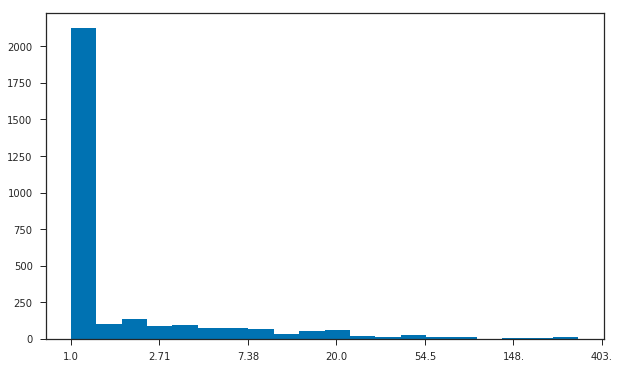

In [18]:
import seaborn as sns
sns.set_palette('colorblind')
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):
    #sns.distplot(np.log(inter_swr_intervals),hist=True,norm_hist=True,bins=50,label='SWR');
    #sns.distplot(np.log(inactive_isi),hist=True,norm_hist=True,bins=25,label='Inactive');
    #sns.distplot(np.log(center_isi),hist=True,norm_hist=True,bins=50,label='Center');
    #sns.distplot(np.log(left_isi),hist=True,norm_hist=True,bins=25,label='Left');
    #sns.distplot(np.log(right_isi),hist=True,norm_hist=True,bins=25,label='Right');
    ax.hist(np.log(right_isi+left_isi),bins=20,label='Same Arm');
    #ax.set_xticks(np.log([1,3,10,30,100,300,1000]))
    ax.set_xticklabels(np.exp(ax.get_xticks()).astype('|U4'))


# Plot firing rate maps of all neurons by detected arm center

/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


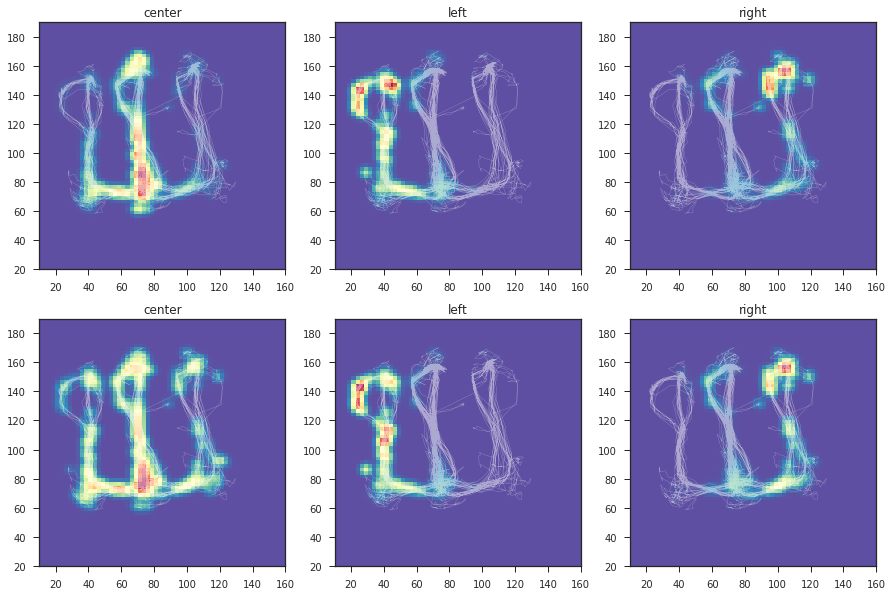

In [19]:
tc = TuningCurves[anim][day]
xx_mid = tc.xbin_centers
yy_mid = tc.ybin_centers

S = data[anim][day]['spikes']
pos = data[anim][day]['pos']

speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)
run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
run_epochs = pos[epochs,:].support.intersect(run_epochs)  
runpos = pos[run_epochs]
xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals


fig, ax = plt.subplots(2, 3, figsize = (15, 10))
axis_order = ['center', 'left', 'right']
for idx, axis in enumerate(axis_order):    
    ax[0,idx].set_aspect('equal')
    all_pfs = tc.ratemap[PF_data[day][:,idx + 5]==1,:,:]
    norm_pfs = all_pfs.T / all_pfs.sum(axis=2).sum(axis=1)
    total_pfs = norm_pfs.mean(axis=2)
    npl.imagesc(x=xx_mid, y=yy_mid, data=total_pfs, cmap=plt.cm.Spectral_r, ax=ax[0,idx])
    ax[0,idx].plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
    ax[0,idx].set_title(axis)

    ax[1,idx].set_aspect('equal')
    all_pfs = tc.ratemap[PF_data[day][:,idx + 5]==1,:,:].sum(axis=0)
    npl.imagesc(x=xx_mid, y=yy_mid, data=all_pfs.T, cmap=plt.cm.Spectral_r, ax=ax[1,idx])
    ax[1,idx].plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
    ax[1,idx].set_title(axis)




# Define left and right 2D maze zones

In [20]:
nx = TuningCurves[anim][day].n_xbins
ny = TuningCurves[anim][day].n_ybins
xx_mid = TuningCurves[anim][day].xbin_centers
yy_mid = TuningCurves[anim][day].ybin_centers

left_pixels = np.zeros((int(nx),int(ny)))
right_pixels = np.zeros((int(nx),int(ny)))
for ix, x in enumerate(xx_mid):
    for iy, y in enumerate(yy_mid):
        left_pixels[ix,iy] = np.cross([x,y] - CenterBounds[0], CenterBounds[5]-CenterBounds[0]) < 0
        right_pixels[ix,iy] = np.cross([x,y] - CenterBounds[2], CenterBounds[3]-CenterBounds[2]) > 0
        

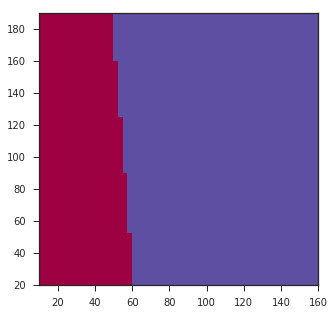

In [21]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_aspect('equal')
ax, img = npl.imagesc(x=xx_mid, y=yy_mid, data=left_pixels.T, cmap=plt.cm.Spectral_r, ax=ax)



/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:898: UserWarning: ignoring spikes outside of spiketrain support


1497.53170838


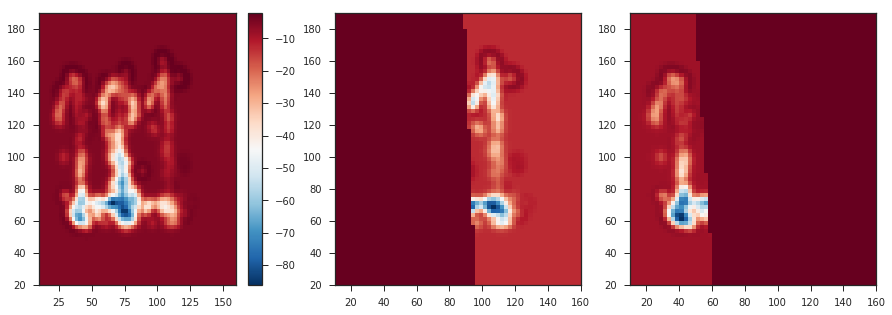

In [22]:
day = 3
tc = TuningCurves[anim][day]
ratemap = tc.ratemap
swr_eps = SWREpochs[anim][day]
S = data[anim][day]['spikes']        
pos = data[anim][day]['pos']
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    not_still_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # bound epochs down to 1 cm/s
    still_epochs = pos[epochs,:].support.intersect(not_still_epochs.complement()) 
    still_pos = pos[epochs,:].support.intersect(still_epochs)

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    all_swr = swr_eps.intersect(pos[epochs,:].support)
# allswrtimes = all_swr.centers
# all_swr = swr_eps.intersect(pos.support[ep])


still_swr = swr_eps.intersect(still_epochs)
stillswrtimes = still_swr.centers
swr_spikes = S[still_swr]
swrtimes = still_swr.centers

swr = swr_spikes[0]
bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
left_odds = (bayes_estimate * left_pixels.T).sum()
right_odds = (bayes_estimate * right_pixels.T).sum()

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_aspect('equal')
ax[0], img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate, cmap=plt.cm.RdBu_r, ax=ax[0])
plt.colorbar(img, ax=ax[0])

ax[1].set_aspect('equal')
a, img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate * right_pixels.T, cmap=plt.cm.RdBu_r, ax=ax[1])

ax[2].set_aspect('equal')
a, img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate * left_pixels.T, cmap=plt.cm.RdBu_r, ax=ax[2])

left_odds = (bayes_estimate * left_pixels.T).sum()
right_odds = (bayes_estimate * right_pixels.T).sum()

print(left_odds-right_odds)


# Decode each ripple's total position and odds over maze zones

In [23]:
def calculate_shuffle_odds(swr, ratemap, left_pixels, right_pixels, n_shuffles=500):
    if swr.n_active == 0:
        return (np.nan, 0)

    NN = ratemap.shape[0]
    bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
    left_odds = (bayes_estimate * left_pixels.T).sum()
    right_odds = (bayes_estimate * right_pixels.T).sum()

    true_odds = left_odds - right_odds

    shuf_odds = []
    for n in range(n_shuffles):
        shuf_rate = ratemap.copy()
        shuf_rate = shuf_rate[np.random.permutation(NN),:,:]
        shuf_est = -shuf_rate.sum(axis=0).T + np.log(shuf_rate.T).dot(swr.n_spikes)
        left_odds = (shuf_est * left_pixels.T).sum()
        right_odds = (shuf_est * right_pixels.T).sum()
        shuf_odds.append(left_odds - right_odds)
        
    return (true_odds, shuf_odds)


In [66]:
from joblib import Parallel, delayed
from scipy import stats
import time


RippleArmScores = {}

for anim, animdata in data.items():
    RippleArmScores[anim] = {}
    
    CenterBounds = NovelCenterBounds[anim]
        
    for day, daydata in animdata.items():
        if (day != 3):
            continue;
        if (anim == 'Fra') & (day == 3):
            epochs = [0,2]
        else:
            epochs = [1,3]
            
        if (anim == 'Con') & (day < 3):
            continue

        nx = TuningCurves[anim][day].n_xbins
        ny = TuningCurves[anim][day].n_ybins
        xx_mid = TuningCurves[anim][day].xbin_centers
        yy_mid = TuningCurves[anim][day].ybin_centers

        left_pixels = np.zeros((int(nx),int(ny)))
        right_pixels = np.zeros((int(nx),int(ny)))
        for ix, x in enumerate(xx_mid):
            for iy, y in enumerate(yy_mid):
                left_pixels[ix,iy] = np.cross([x,y] - CenterBounds[0], 
                                              CenterBounds[5]-CenterBounds[0]) < 0
                right_pixels[ix,iy] = np.cross([x,y] - CenterBounds[2], 
                                               CenterBounds[3]-CenterBounds[2]) > 0

            
        ratemap = TuningCurves[anim][day].ratemap
        swr_eps = SWREpochs[anim][day]
        S = daydata['spikes']        
        pos = daydata['pos']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            not_still_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=5) # bound epochs down to 3 cm/s
            still_epochs = pos[epochs,:].support.intersect(not_still_epochs.complement()) 
            still_pos = pos[epochs,:].support.intersect(still_epochs)

        #with warnings.catch_warnings():
        #    warnings.simplefilter("ignore")
        #    all_swr = swr_eps.intersect(pos[epochs,:].support)
        # allswrtimes = all_swr.centers
        # all_swr = swr_eps.intersect(pos.support[ep])

        still_swr = swr_eps.intersect(still_epochs)
        print(anim, day, still_swr.n_epochs, 'ripples')

        if (still_swr.n_epochs < 20):
            continue
        
        RippleArmScores[anim][day] = {}
        
        # Make all events 150 ms long
        centers = still_swr.centers
        new_bnds = np.vstack([centers-0.025, centers+0.025])
        new_epochs = nel.EpochArray(new_bnds.T)

        # RippleArmScores[anim][day]['RippleEpochs'] = still_swr
        RippleArmScores[anim][day]['RippleEpochs'] = new_epochs

        swr_spikes = S[new_epochs]

        t0 = time.time()
        results = Parallel(n_jobs=60)(delayed(calculate_shuffle_odds)(swr, 
                                ratemap*0.05, left_pixels, right_pixels) for swr in swr_spikes)
        t1 = time.time()
        print('Done in ', t1-t0, 's')

        true_odds, shuf_odds = zip(*results)

        RippleArmScores[anim][day]['TrueOdds'] = true_odds
        RippleArmScores[anim][day]['OddsShuffles'] = shuf_odds

        shuf_ratio = []
        for idx, t in enumerate(true_odds):
            if not np.isnan(t):
                shuf_ratio.append(stats.percentileofscore(shuf_odds[idx],t))
            else:
                shuf_ratio.append(np.nan)
                
        shuf_ratio = np.array(shuf_ratio)
        shuf_ratio2 = np.zeros(shuf_ratio.shape)
        shuf_ratio2[shuf_ratio > 75] = 1.0
        shuf_ratio2[shuf_ratio < 25] = -1.0

        RippleArmScores[anim][day]['TruePercentiles'] = shuf_ratio2
        
        # swrtimes = still_swr.starts
        swrtimes = new_epochs.centers
        isi = np.insert(np.diff(swrtimes),0,-np.nan)

        RippleArmScores[anim][day]['TimeSinceLastRipple'] = isi
        RippleArmScores[anim][day]['ScoreOfLastRipple'] = np.hstack([0, shuf_ratio2[:-1]])
#         RippleArmScores[anim][day]['ScoreOfLastRipple'] = np.hstack([np.nan, shuf_ratio2[:-1]])
        
        print(len(isi), len(np.hstack([shuf_ratio[1:], np.nan])))

    break; # just do Bon
    

Bon 3 229 ripples
Done in  87.11559295654297 s
229 229


/home/kemerelab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in greater
/home/kemerelab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less


In [51]:
shuf_ratio2

array([ 0., -1., -1.,  0., -1., -1., -1.,  0.,  0.,  0.,  1., -1.,  0.,
       -1.,  0., -1., -1.,  1.,  0., -1., -1., -1.,  0.,  0., -1., -1.,
       -1., -1.,  0.,  1., -1., -1.,  0.,  1., -1.,  0.,  1., -1.,  0.,
       -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,
        0.,  1.,  0.,  0.,  1., -1., -1., -1., -1., -1.,  1., -1.,  0.,
        0.,  0.,  1., -1.,  1.,  0.,  0., -1., -1.,  1.,  1., -1.,  0.,
       -1., -1.,  0., -1., -1.,  0.,  0., -1.,  0., -1., -1.,  0., -1.,
       -1.,  0.,  1., -1.,  1.,  1.,  1.,  0.,  1., -1.,  1.,  1.,  1.,
        0.,  0.,  0., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,
        1., -1.,  0., -1.,  1.,  0.,  0., -1., -1.,  1., -1.,  0., -1.,
       -1., -1.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0., -1., -1.,  0.,
        0.,  0.,  1.,  0.,  1., -1., -1.,  0., -1.,  0., -1.,  0., -1.,
        0., -1.,  0., -1.,  1.,  0., -1., -1., -1., -1.,  1., -1.,  1.,
       -1.,  0.,  0., -1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0

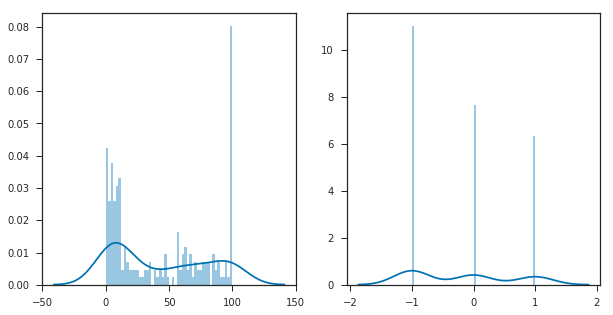

In [62]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sr = np.array(shuf_ratio)
sns.distplot(sr[~np.isnan(sr)],50, ax=ax[0])

sr = np.array(shuf_ratio2)
sns.distplot(sr[~np.isnan(sr)],50, ax=ax[1])

In [68]:
all_score_diffs = []
all_score_diffs_shuff = []
all_last_times = []
NShuf = 500

for anim, ripscores in RippleArmScores.items():
    shuf_ratios = []
    last_ratios = []
    last_times = []
    score_diffs = []
    shuff_score_diffs = []
    for day, datum in ripscores.items():
        sc = np.array(datum['TruePercentiles'])
        if (len(sc[~np.isnan(sc)]) == 0):
            continue
            
        shuf_ratios.append(sc)
        lastsc = np.array(datum['ScoreOfLastRipple'])
        last_ratios.append(lastsc)
        lastT = np.array(datum['TimeSinceLastRipple'])
        last_times.append(lastT)
#        score_diffs.append(np.abs(sc - lastsc))
        score_diffs.append(sc*lastsc)
        
        # now we want to generate shuffle distribution of score_diffs
        shuffs = np.zeros((len(sc),NShuf))
        for idx in range(NShuf):
#            shuffs[:,idx] = np.abs(np.random.permutation(sc) - lastsc)
            shuffs[:,idx] = np.random.permutation(sc)*lastsc
        shuff_score_diffs.append(shuffs)
        
        print(day, sc.shape, lastT.shape, lastsc.shape, shuffs.shape)


    all_shuf_ratios = np.hstack(shuf_ratios)
    all_score_diffs.append(np.hstack(score_diffs))
    all_score_diffs_shuff.append(np.vstack(shuff_score_diffs))
    all_last_times.append(np.hstack(last_times))


3 (229,) (229,) (229,) (229, 500)


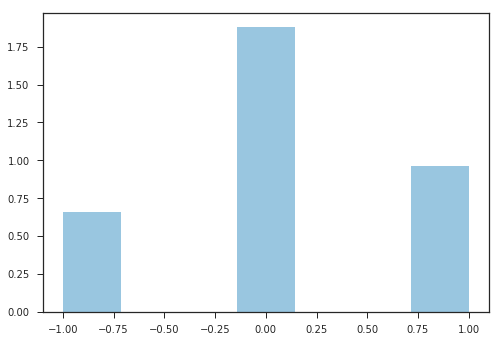

In [73]:
sns.distplot(score_diffs[0], norm_hist=True, kde=False)

In [78]:
print(np.mean(score_diffs[0] == 1))
print(np.mean(np.hstack(shuff_score_diffs[0]) == 1))

0.275109170306
0.252602620087


In [117]:

bins = np.linspace(-5,5,11)
# actual_diff = sc - lastsc
# actual_diff2 = actual_diff[~np.isnan(actual_diff)]
actual_diff = sc*lastsc
hactual, _ = np.histogram(actual_diff, bins=bins)

lastT[0] = 10

# true_vals, tbins , _ = stats.binned_statistic(np.log10(lastT[~np.isnan(actual_diff)]), actual_diff2, 'mean', bins=20)
true_vals, tbins , _ = stats.binned_statistic(np.log10(lastT), actual_diff, 'mean', bins=20)


shuf_scores = []
sh_val_list = []
for idx in range(NShuf):
#    shsc = np.random.permutation(sc) - lastsc
    shsc = np.random.permutation(sc)*lastsc
    shuf_scores.append(shsc)
    sh_hists.append(h)
    
#    sh_vals, _, _ = stats.binned_statistic(np.log10(lastT[~np.isnan(shsc)]), shsc2, 'mean', bins=tbins)
    sh_vals, _, _ = stats.binned_statistic(np.log10(lastT), shsc, 'mean', bins=tbins)
    sh_val_list.append(sh_vals)

    



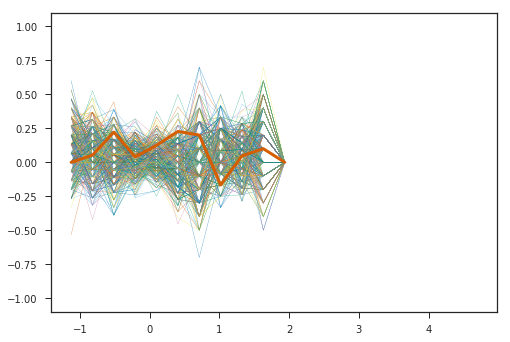

In [90]:
plt.plot(tbins[:-1], np.vstack(sh_val_list).T, lw=0.25);
plt.plot(tbins[:-1], true_vals, lw=3)


In [ ]:
sns.distplot(actual_diff[]

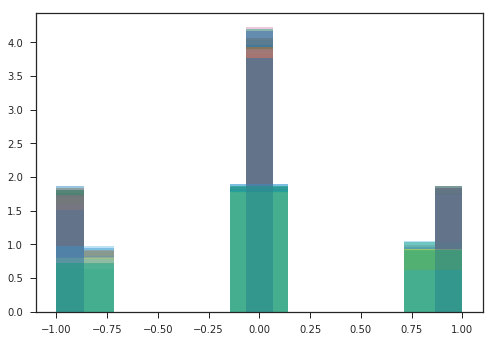

In [122]:
for idx in range(50):
    sns.distplot(shuf_scores[idx], kde=False, norm_hist=True)

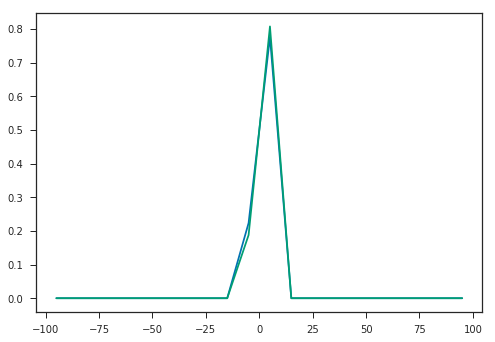

In [60]:
plt.plot(np.linspace(-95,95,20), np.vstack(sh_hists).mean(axis=0));
plt.plot(np.linspace(-95,95,20), hactual/len(actual_diff));

In [ ]:
true_vals, true_binedges, binnumber = stats.binned_statistic(np.log10(t), scdiff, 'mean', bins=50)


In [ ]:
from scipy import stats

t = np.hstack(all_last_times)
scdiff = np.hstack(all_score_diffs)
good = ~np.isnan(t) & ~np.isnan(scdiff)
t = t[good]
scdiff = scdiff[good]
true_vals, true_binedges, binnumber = stats.binned_statistic(np.log10(t), scdiff, 'mean', bins=50)
bincenters = binedges[:-1] + (binedges[1] - binedges[0])/2

scdiff_shuff = np.vstack(all_score_diffs_shuff)
shuf_vals = []
for idx in range(NShuf):
    t = np.hstack(all_last_times)
    scdiff = scdiff_shuff[:,idx]
    good = ~np.isnan(t) & ~np.isnan(scdiff)
    t = t[good]
    scdiff = scdiff[good]
    vals, _, _ = stats.binned_statistic(np.log10(t), scdiff, 'mean', bins=true_binedges)
    shuf_vals.append(vals)



In [ ]:
shuf_vals[0].shape

In [ ]:
plt.plot(bincenters, np.vstack(shuf_vals).T);
plt.plot(bincenters, vals,linewidth=3)


# Add up look at what the score of the previous event was

In [ ]:
for anim, ripscores in RippleArmScores.items():
    shuf_ratios = []
    total_nans = 0
    for day, datum in ripscores.items():
        sc = np.array(datum['TruePercentiles'])
        print(day, sc.shape, len(sc[~np.isnan(sc)]))
        if (len(sc[~np.isnan(sc)]) == 0):
            continue
        shuf_ratios.append(sc[~np.isnan(sc)])
        total_nans += np.isnan(sc).sum()

    all_shuf_ratios = np.hstack(shuf_ratios)
